In [2]:
# to read input images from several recording sessions, the CSV log files must be merged.
# all log files are stored in the log_path
# all recorded images are stored in the img_path

# Combining the log files here gives the advantage, that the steering correction value for the left and right image is still adjustable. 

import os
import pandas as pd 

df = pd.DataFrame()  # create an empty dataframe
steering_correction = 0.2 # will be applied on the steering angle for the left and right image

log_path = "TrainingDataTrack0/driving_log/"
img_path = "TrainingDataTrack0/IMG/"

# loop over all log files from the recordings and will combine them
for file in os.listdir(log_path):
    print("Read file: " + file)

    data = pd.read_csv(log_path + file, header=None) 
    
    center = data.iloc[:, [0, 3]] # df with two columns: center images and the steering angle

    left = data[[1, 3]].copy()  # df with two columns: left images and the steering angle
    left[[3]] += steering_correction  # adjust the steering angle by the correction value
    
    right = data[[2, 3]].copy() # df with two columns: right images and the steering angle
    right[[3]] -= steering_correction # adjust the steering angle by the correction value
    center.columns, left.columns, right.columns = [0, 1], [0, 1], [0, 1] # give all the dataframes the same column names that they can be appended
    
    df = df.append(center, ignore_index=True)
    df = df.append(left, ignore_index=True)
    df = df.append(right, ignore_index=True)


    
df.columns = ["filename", "steering"] # rename the column names
filenames = df["filename"].apply(lambda x: x.split('\\')[-1])  # just store the filename in col 0, not the complete path
df[["filename"]] = filenames

print(df.head())
print(df.index)

Read file: driving_log0.csv
Read file: driving_log2.csv
Read file: driving_log3.csv
Read file: driving_log4.csv
Read file: driving_log5.csv
                             filename  steering
0  center_2019_03_09_08_16_18_692.jpg      0.00
1  center_2019_03_09_08_16_18_767.jpg      0.00
2  center_2019_03_09_08_16_18_838.jpg      0.00
3  center_2019_03_09_08_16_18_909.jpg      0.00
4  center_2019_03_09_08_16_18_978.jpg     -0.15
RangeIndex(start=0, stop=73194, step=1)


In [10]:
# create a CNN that is capable of the E2E learning. The used CNN is the architecture of the E2E learing Nvidia paper

from keras.models import Sequential
from keras.layers import Lambda, Conv2D, MaxPool2D, Dropout, Dense, Flatten, Cropping2D
from keras.optimizers import Adam

model = Sequential()
model.add(Cropping2D(cropping=((70, 25), (0,0)), input_shape=(160, 320, 3)))
model.add(Lambda(lambda x: x/255 - 0.5))
model.add(Conv2D(24, (5, 5), activation="elu", subsample=(2,2)))
model.add(Conv2D(36, (5, 5), activation="elu", subsample=(2,2)))
model.add(Conv2D(48, (5, 5), activation="elu", subsample=(2,2)))
model.add(Conv2D(64, (3, 3), activation="elu"))
model.add(Conv2D(64, (3, 3), activation="elu"))
model.add(Dropout(0.7))
model.add(Flatten())
model.add(Dense(100, activation="elu"))
model.add(Dense(50, activation="elu"))
model.add(Dense(10, activation="elu"))
model.add(Dense(1))
model.summary()




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_3 (Cropping2D)    (None, 65, 320, 3)        0         
_________________________________________________________________
lambda_3 (Lambda)            (None, 65, 320, 3)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 31, 158, 24)       1824      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 14, 77, 36)        21636     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 5, 37, 48)         43248     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 3, 35, 64)         27712     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 1, 33, 64)         36928     
__________

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), activation="elu", strides=(2, 2))`
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  if sys.path[0] == '':


In [12]:
# Train the CNN using the flow_from_dataframe image data generator.
# The image data generator is also used for data augmentation - with shifting and zooming the number of training images is increased
# Horizontal flip is not used because I didn´t know how the corresponding steering value can be inverted.

from keras.preprocessing.image import ImageDataGenerator


datagen = ImageDataGenerator(
    rescale=1,#./255,
    #rotation_range=20,
    zoom_range=0.1,
    width_shift_range=5,
    height_shift_range=5,
    horizontal_flip=False,
)
    #preprocessing_function=preprocess_input)

train_generator=datagen.flow_from_dataframe(dataframe=df, 
                                            directory=img_path, 
                                            shuffle=True, 
                                            x_col="filename", 
                                            y_col="steering", 
                                            class_mode="other", 
                                            target_size=(160,320), 
                                            batch_size=32
                                           )


model.compile(loss="mse", optimizer=Adam(lr=0.0001))  # mse because it is a regression not a classification task
history_object = model.fit_generator(train_generator, epochs=5, workers=8, steps_per_epoch=156, verbose=2)

Found 73194 images.
Epoch 1/5
 - 9s - loss: 0.0599
Epoch 2/5
 - 8s - loss: 0.0461
Epoch 3/5
 - 9s - loss: 0.0429
Epoch 4/5
 - 9s - loss: 0.0403
Epoch 5/5
 - 9s - loss: 0.0402


In [13]:
# Further training

history_object = model.fit_generator(train_generator, epochs=10, workers=8, steps_per_epoch=156, verbose=2) # one epoche = 90s 

Epoch 1/10
 - 9s - loss: 0.0375
Epoch 2/10
 - 9s - loss: 0.0366
Epoch 3/10
 - 9s - loss: 0.0375
Epoch 4/10
 - 9s - loss: 0.0358
Epoch 5/10
 - 9s - loss: 0.0346
Epoch 6/10
 - 9s - loss: 0.0373
Epoch 7/10
 - 9s - loss: 0.0336
Epoch 8/10
 - 9s - loss: 0.0334
Epoch 9/10
 - 9s - loss: 0.0339
Epoch 10/10
 - 9s - loss: 0.0338


In [14]:
# Store the model

model.save("model.h5")

dict_keys(['loss'])


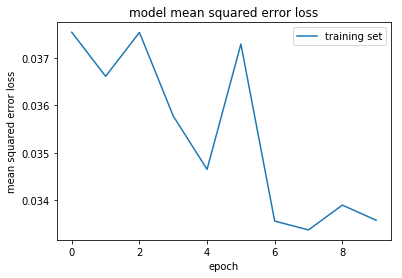

In [15]:
import matplotlib.pyplot as plt


### plot the training loss for each epoch
plt.plot(history_object.history['loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set'], loc='upper right')
plt.show()